<a href="https://colab.research.google.com/github/sudarshan-360/Machine-Learning/blob/main/Untitled7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install -q mediapipe opencv-python-headless tensorflow==2.13.0 tensorflow-addons xgboost scikit-learn pandas matplotlib seaborn tqdm


In [19]:
import os, io, math, pickle, shutil, sys
from pathlib import Path
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import mediapipe as mp

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

# optional tfa
try:
    import tensorflow_addons as tfa
    HAVE_TFA = True
except Exception:
    HAVE_TFA = False

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.19.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

In [20]:
BASE_DIR = "/mnt/data"
IMAGES_DIR = os.path.join(BASE_DIR, "images")
CACHE_DIR = os.path.join(BASE_DIR, "skin_cache")
MODEL_SAVE_PATH = os.path.join(BASE_DIR, "skin_tone_model.h5")
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
TOP_K = 5  # top recommendations to return

os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(CACHE_DIR, exist_ok=True)

# 3) Upload dataset, optional rules CSV, and images
from google.colab import files
print("1) Upload your main dataset CSV (saree_color_dataset_with_skinundertone_5000.csv):")
uploaded = files.upload()
if len(uploaded)==0:
    raise SystemExit("No dataset uploaded. Re-run and upload the CSV.")
dataset_fn = list(uploaded.keys())[0]
DATASET_PATH = os.path.join(BASE_DIR, dataset_fn)
open(DATASET_PATH,"wb").write(uploaded[dataset_fn])
print("Saved dataset to:", DATASET_PATH)

print("\n2) (Optional) Upload a cultural rules CSV (format: SkinTone,AllowedBodyColors (pipe-separated) ). If you skip, defaults will be used.")
uploaded2 = files.upload()
RULES_PATH = None
if len(uploaded2)>0:
    rules_fn = list(uploaded2.keys())[0]
    RULES_PATH = os.path.join(BASE_DIR, rules_fn)
    open(RULES_PATH,"wb").write(uploaded2[rules_fn])
    print("Saved rules to:", RULES_PATH)
else:
    print("No rules CSV uploaded — using built-in defaults.")

print("\n3) Upload face images (multi-select). Filenames should match dataset 'Image' column if present.")
uploaded_imgs = files.upload()
count = 0
for fn, data in uploaded_imgs.items():
    outp = os.path.join(IMAGES_DIR, fn)
    open(outp, "wb").write(data)
    count += 1
print(f"Saved {count} images to {IMAGES_DIR} (if any).")

1) Upload your main dataset CSV (saree_color_dataset_with_skinundertone_5000.csv):


Saving saree_color_dataset_with_skinundertone_5000.csv to saree_color_dataset_with_skinundertone_5000 (3).csv
Saved dataset to: /mnt/data/saree_color_dataset_with_skinundertone_5000 (3).csv

2) (Optional) Upload a cultural rules CSV (format: SkinTone,AllowedBodyColors (pipe-separated) ). If you skip, defaults will be used.


No rules CSV uploaded — using built-in defaults.

3) Upload face images (multi-select). Filenames should match dataset 'Image' column if present.


Saving portrait-young-black-man-7542628.webp to portrait-young-black-man-7542628 (2).webp
Saved 1 images to /mnt/data/images (if any).


In [21]:
mp_face_mesh = mp.solutions.face_mesh
mp_selfie = mp.solutions.selfie_segmentation

LEFT_CHEEK_IDS  = [454, 356, 447, 345, 346]
RIGHT_CHEEK_IDS = [234, 93, 132, 58, 172]

def extract_region(image_rgb, face_landmarks, landmark_ids):
    h, w, _ = image_rgb.shape
    pts = []
    for idx in landmark_ids:
        lm = face_landmarks.landmark[idx]
        x = int(max(0, min(w-1, lm.x * w)))
        y = int(max(0, min(h-1, lm.y * h)))
        pts.append((x,y))
    if len(pts)==0:
        return None
    xs = [p[0] for p in pts]; ys = [p[1] for p in pts]
    x1, x2 = max(0, min(xs)-5), min(w-1, max(xs)+5)
    y1, y2 = max(0, min(ys)-5), min(h-1, max(ys)+5)
    if x2 - x1 <= 5 or y2 - y1 <= 5:
        return None
    return image_rgb[y1:y2, x1:x2]

def extract_cheek_and_skin_mask(img_path):
    """Return (cheek_rgb, skin_only_rgb, mask) or (None,None,None)"""
    bgr = cv2.imread(img_path)
    if bgr is None:
        return None, None, None
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1) as fm:
        res = fm.process(rgb)
        if not res.multi_face_landmarks:
            return None, None, None
        lm = res.multi_face_landmarks[0]
        left = extract_region(rgb, lm, LEFT_CHEEK_IDS)
        right = extract_region(rgb, lm, RIGHT_CHEEK_IDS)
        if left is None and right is None:
            # fallback to full face bbox
            xs = [int(p.x * rgb.shape[1]) for p in lm.landmark]
            ys = [int(p.y * rgb.shape[0]) for p in lm.landmark]
            x1, x2 = max(0, min(xs)-10), min(rgb.shape[1]-1, max(xs)+10)
            y1, y2 = max(0, min(ys)-10), min(rgb.shape[0]-1, max(ys)+10)
            face_crop = rgb[y1:y2, x1:x2]
        else:
            if left is None: face_crop = right
            elif right is None: face_crop = left
            else:
                try:
                    right_resized = cv2.resize(right, (left.shape[1], left.shape[0]))
                    face_crop = np.concatenate([left, right_resized], axis=1)
                except:
                    face_crop = left
    # segmentation on face_crop
    with mp_selfie.SelfieSegmentation(model_selection=1) as seg:
        segres = seg.process(cv2.cvtColor(face_crop, cv2.COLOR_RGB2BGR))
        if segres.segmentation_mask is None:
            return face_crop, None, None
        mask = (segres.segmentation_mask > 0.5).astype(np.uint8) * 255
        kernel = np.ones((3,3), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        skin_only = cv2.bitwise_and(face_crop, face_crop, mask=mask)
        return face_crop, skin_only, mask


In [22]:
df = pd.read_csv(DATASET_PATH)
print("Dataset loaded:", DATASET_PATH)
print("Columns:", df.columns.tolist())
print("Rows:", len(df))

# required columns we expect (attempt to handle variants)
label_candidates = ["SkinUndertone","Skin_Tone","Undertone","skin_tone","skinundertone"]
label_col = None
for c in label_candidates:
    if c in df.columns:
        label_col = c; break
if label_col is None:
    # attempt fuzzy search
    for c in df.columns:
        if "skin" in c.lower() and ("tone" in c.lower() or "undertone" in c.lower()):
            label_col = c; break
if label_col is None:
    raise SystemExit("Could not find skin label column — rename to one of: " + ", ".join(label_candidates))

print("Using skin label column:", label_col)
df[label_col] = df[label_col].astype(str).str.strip()

# detect image filename column (optional)
image_col = None
for c in ["Image","image","Filename","File","file","img","filename"]:
    if c in df.columns:
        image_col = c; break
if image_col:
    print("Detected image filename column in CSV:", image_col)
else:
    print("No image filename column in CSV — HSV centroids will only be computed for matching uploaded files.")

# ensure feature columns exist; create placeholders if missing
feature_cols = ["BodyColor","BorderColor","FabricType","ZariType","BorderType","Pattern","Occasion","Rating"]
for fc in feature_cols:
    if fc not in df.columns:
        df[fc] = np.nan

# prepare label encoder for undertone
le = LabelEncoder()
df["label_enc"] = le.fit_transform(df[label_col])
labels = list(le.classes_)
print("Detected label classes (dataset):", labels)


Dataset loaded: /mnt/data/saree_color_dataset_with_skinundertone_5000 (3).csv
Columns: ['Skin Tone', 'Undertone', 'Body Color', 'Border Color', 'Zari Type', 'Technique', 'Pattern', 'Fabric Purity', 'Border Type', 'Material', 'Blouse', 'Pallu Style', 'Event Type', 'Price Range', 'Weight Category']
Rows: 5000
Using skin label column: Undertone
No image filename column in CSV — HSV centroids will only be computed for matching uploaded files.
Detected label classes (dataset): ['Cool', 'Neutral', 'Warm']


In [23]:
if RULES_PATH and os.path.exists(RULES_PATH):
    rules_df = pd.read_csv(RULES_PATH)
    # Expect columns: SkinTone, AllowedBodyColors (pipe separated)
    rules_map = {}
    for _, r in rules_df.iterrows():
        key = str(r.iloc[0]).strip()
        colors = str(r.iloc[1]).split("|") if len(r)>=2 and pd.notna(r.iloc[1]) else []
        rules_map[key] = [c.strip() for c in colors if c.strip()]
    print("Loaded rules from:", RULES_PATH)
else:
    # default cultural rules (you can tweak these)
    rules_map = {
        "Fair": ["peach","light pink","sky blue","mint green","lavender","cream","soft yellow"],
        "Wheatish": ["maroon","mustard","teal","olive green","coral","rust","peach"],
        "Dusky": ["royal blue","emerald green","wine","gold","deep purple","deep red","navy"]
    }
    print("Using default rules_map (can upload a rules CSV to override).")

Using default rules_map (can upload a rules CSV to override).


In [25]:
# --- Replace earlier MediaPipe usage with this robust init + extraction + fallback ---

# Initialize MediaPipe once and create Haar fallback
mediapipe_available = True
face_mesh = None
selfie_seg = None
try:
    # Initialize FaceMesh and SelfieSegmentation ONCE
    face_mesh = mp.solutions.face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=False,          # safer & lighter; set True only if you need iris refinement
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    )
    selfie_seg = mp.solutions.selfie_segmentation.SelfieSegmentation(model_selection=1)
    print("✅ MediaPipe FaceMesh + SelfieSegmentation initialized.")
except Exception as e:
    print("⚠️ MediaPipe init failed:", type(e).__name__, e)
    print("Falling back to Haar cascade + YCrCb skin detection.")
    mediapipe_available = False
    face_mesh = None
    selfie_seg = None

# Haar cascade fallback (always available with OpenCV)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
if face_cascade.empty():
    print("⚠️ Haar cascade failed to load (unexpected).")

# Keep the same cheek landmark IDs you used earlier
LEFT_CHEEK_IDS  = [454, 356, 447, 345, 346]
RIGHT_CHEEK_IDS = [234, 93, 132, 58, 172]

def extract_region(image_rgb, face_landmarks, landmark_ids):
    h, w, _ = image_rgb.shape
    pts = []
    for idx in landmark_ids:
        lm = face_landmarks.landmark[idx]
        x = int(max(0, min(w-1, lm.x * w)))
        y = int(max(0, min(h-1, lm.y * h)))
        pts.append((x,y))
    if len(pts) == 0: return None
    xs = [p[0] for p in pts]; ys = [p[1] for p in pts]
    x1, x2 = max(0, min(xs)-5), min(w-1, max(xs)+5)
    y1, y2 = max(0, min(ys)-5), min(h-1, max(ys)+5)
    if x2 - x1 <= 5 or y2 - y1 <= 5: return None
    return image_rgb[y1:y2, x1:x2]

def extract_cheek_and_skin_mask(img_path):
    """
    Robust cheek ROI + skin-only mask extractor.
    Returns: (face_crop_rgb, skin_only_rgb, mask_uint8) or (None, None, None)
    Uses MediaPipe if available, otherwise falls back to OpenCV Haar + YCrCb skin detection.
    """
    bgr = cv2.imread(img_path)
    if bgr is None:
        return None, None, None
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    # Try MediaPipe face mesh + selfie segmentation (fast if already initialized)
    if mediapipe_available and face_mesh is not None:
        try:
            mp_result = face_mesh.process(rgb)
            if mp_result and mp_result.multi_face_landmarks:
                lm = mp_result.multi_face_landmarks[0]
                left = extract_region(rgb, lm, LEFT_CHEEK_IDS)
                right = extract_region(rgb, lm, RIGHT_CHEEK_IDS)

                if left is None and right is None:
                    # fallback to face bbox from landmarks
                    xs = [int(p.x * rgb.shape[1]) for p in lm.landmark]
                    ys = [int(p.y * rgb.shape[0]) for p in lm.landmark]
                    x1, x2 = max(0, min(xs)-10), min(rgb.shape[1]-1, max(xs)+10)
                    y1, y2 = max(0, min(ys)-10), min(rgb.shape[0]-1, max(ys)+10)
                    face_crop = rgb[y1:y2, x1:x2]
                else:
                    if left is None: face_crop = right
                    elif right is None: face_crop = left
                    else:
                        try:
                            right_resized = cv2.resize(right, (left.shape[1], left.shape[0]))
                            face_crop = np.concatenate([left, right_resized], axis=1)
                        except Exception:
                            face_crop = left

                # Use selfie_segmentation to get skin mask on face_crop
                if selfie_seg is not None and face_crop is not None:
                    seg_res = selfie_seg.process(cv2.cvtColor(face_crop, cv2.COLOR_RGB2BGR))
                    if seg_res and getattr(seg_res, "segmentation_mask", None) is not None:
                        mask = (seg_res.segmentation_mask > 0.5).astype(np.uint8) * 255
                        kernel = np.ones((3,3), np.uint8)
                        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
                        skin_only = cv2.bitwise_and(face_crop, face_crop, mask=mask)
                        return face_crop, skin_only, mask
                # If segmentation not available, just return face_crop (no mask)
                return face_crop, None, None
            else:
                # MediaPipe processed but found no face -> fall back
                pass
        except Exception as e:
            # If MediaPipe runtime fails mid-processing, fallback to Haar
            print("⚠️ MediaPipe processing error — falling back to Haar:", type(e).__name__, e)

    # --- Fallback: Haar cascade face detection + simple YCrCb skin mask ---
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(60,60))
    if len(faces) == 0:
        return None, None, None
    x, y, w, h = faces[0]   # take the first detected face
    face_crop = rgb[y:y+h, x:x+w]

    # Skin detection in YCrCb color space (commonly used threshold)
    ycrcb = cv2.cvtColor(face_crop, cv2.COLOR_RGB2YCrCb)
    cr = ycrcb[:,:,1]; cb = ycrcb[:,:,2]
    mask = np.zeros(cr.shape, dtype=np.uint8)
    # common thresholds for skin in YCrCb (may be adjusted)
    mask[(cr >= 133) & (cr <= 173) & (cb >= 77) & (cb <= 127)] = 255
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    skin_only = cv2.bitwise_and(face_crop, face_crop, mask=mask)
    return face_crop, skin_only, mask

# Optional: call this after your whole processing to free MediaPipe resources
def close_mediapipe():
    global face_mesh, selfie_seg
    try:
        if face_mesh is not None:
            face_mesh.close()
        if selfie_seg is not None:
            selfie_seg.close()
    except Exception:
        pass


⚠️ MediaPipe init failed: RuntimeError Failed to parse: node {
  calculator: "ImagePropertiesCalculator"
  input_stream: "IMAGE:image"
  output_stream: "SIZE:image_size"
}
node {
  calculator: "PreviousLoopbackCalculator"
  input_stream: "MAIN:image"
  input_stream: "LOOP:face_rects_from_landmarks"
  output_stream: "PREV_LOOP:prev_face_rects_from_landmarks"
  input_stream_info {
    tag_index: "LOOP"
    back_edge: true
  }
}
node {
  calculator: "GateCalculator"
  input_stream: "prev_face_rects_from_landmarks"
  output_stream: "gated_prev_face_rects_from_landmarks"
  input_side_packet: "ALLOW:use_prev_landmarks"
  options {
    [mediapipe.GateCalculatorOptions.ext] {
      allow: true
    }
  }
}
node {
  calculator: "NormalizedRectVectorHasMinSizeCalculator"
  input_stream: "ITERABLE:gated_prev_face_rects_from_landmarks"
  output_stream: "prev_has_enough_faces"
  input_side_packet: "num_faces"
}
node {
  calculator: "GateCalculator"
  input_stream: "image"
  input_stream: "DISALLOW:p

In [26]:
tone_hsv_map = {}
for lab in df[label_col].unique():
    sub = df[df[label_col]==lab]
    try:
        h_mean = float(sub["H"].dropna().astype(float).mean())
        s_mean = float(sub["S"].dropna().astype(float).mean())
        v_mean = float(sub["V"].dropna().astype(float).mean())
    except:
        continue
    if not (np.isnan(h_mean) or np.isnan(s_mean) or np.isnan(v_mean)):
        tone_hsv_map[lab] = np.array([h_mean, s_mean, v_mean])
print("Tone HSV centroids computed for:", list(tone_hsv_map.keys()))

def classify_hsv_nearest(hsv):
    best = None; bestd = 1e9
    for lab, cent in tone_hsv_map.items():
        d = np.linalg.norm(np.array(hsv) - cent)
        if d < bestd:
            bestd = d; best = lab
    return best

Tone HSV centroids computed for: []


In [27]:
labelled_rois = [r for r in rois_meta if r["label_enc"] is not None]
trained_model = None
use_fallback = (len(labelled_rois) < 50)  # require >=50 labeled rois to attempt training

if not use_fallback:
    print("Training CNN on extracted cheek ROIs (transfer learning)...")
    # prepare meta DF
    meta_df = pd.DataFrame(labelled_rois)
    # drop rows with missing label_enc
    meta_df = meta_df.dropna(subset=["label_enc"]).reset_index(drop=True)
    meta_df["label_enc"] = meta_df["label_enc"].astype(int)
    train_df, val_df = train_test_split(meta_df, test_size=0.15, stratify=meta_df["label_enc"], random_state=42)
    def _load(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32)/255.0
        return img, label
    def make_ds(dfm, augment=False):
        ds = tf.data.Dataset.from_tensor_slices((dfm["image_file"].values, dfm["label_enc"].values))
        ds = ds.shuffle(buffer_size=len(dfm)).map(lambda p,l: tf.py_function(lambda a,b: _load(a,b), [p,l],[tf.float32, tf.int64]), num_parallel_calls=tf.data.AUTOTUNE)
        def _map_clean(img, lab):
            img.set_shape((*IMG_SIZE,3)); lab.set_shape(())
            return img, lab
        ds = ds.map(_map_clean, num_parallel_calls=tf.data.AUTOTUNE)
        if augment:
            def aug_fn(img, lab):
                img = tf.image.random_flip_left_right(img)
                img = tf.image.random_brightness(img, 0.12)
                img = tf.image.random_contrast(img, 0.9, 1.1)
                img = tf.image.random_saturation(img, 0.9, 1.2)
                if HAVE_TFA:
                    angle = tf.random.uniform([], -0.08, 0.08)
                    img = tfa.image.rotate(img, angle)
                return img, lab
            ds = ds.map(aug_fn, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        return ds
    train_ds = make_ds(train_df, augment=True)
    val_ds = make_ds(val_df, augment=False)
    # backbone
    try:
        base = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(*IMG_SIZE,3), pooling='avg', weights='imagenet')
        preprocess_fn = tf.keras.applications.efficientnet.preprocess_input
    except:
        base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(*IMG_SIZE,3), pooling='avg', weights='imagenet')
        preprocess_fn = tf.keras.applications.mobilenet_v2.preprocess_input
    base.trainable = False
    inp = layers.Input(shape=(*IMG_SIZE,3))
    x = layers.Lambda(preprocess_fn)(inp)
    x = base(x, training=False)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(len(labels), activation='softmax')(x)
    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    ckpt = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)
    es = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
    # class weights
    counts = train_df['label_enc'].value_counts().to_dict(); total = sum(counts.values())
    class_weight = {int(k): float(max(1.0, total/(len(counts)*v))) for k,v in counts.items()}
    print("Class weights:", class_weight)
    hist = model.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=[ckpt,es,rlr], class_weight=class_weight)
    model.save(MODEL_SAVE_PATH)
    trained_model = model
    print("CNN trained and saved at:", MODEL_SAVE_PATH)
else:
    print("Not enough labeled ROIs to train CNN — using HSV centroid fallback.")

# If model file exists but not loaded, try to load
if os.path.exists(MODEL_SAVE_PATH) and trained_model is None:
    try:
        trained_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
        print("Loaded saved CNN model from:", MODEL_SAVE_PATH)
    except Exception as e:
        print("Could not load saved model:", e)
        trained_model = None


Not enough labeled ROIs to train CNN — using HSV centroid fallback.


In [28]:
train_df = df.copy()
# drop rows missing BodyColor (can't recommend)
train_df = train_df.dropna(subset=["BodyColor"]).reset_index(drop=True)

# For ranking label: if Rating column present use it, else create a proxy score using frequency/popularity
if "Rating" in train_df.columns and pd.api.types.is_numeric_dtype(train_df["Rating"]):
    train_df["score"] = train_df["Rating"].astype(float)
else:
    # proxy: combos that appear more often get higher score
    train_df["combo"] = train_df["BodyColor"].astype(str) + "||" + train_df["BorderColor"].astype(str)
    freq = train_df["combo"].value_counts(normalize=True)
    train_df["score"] = train_df["combo"].map(freq).fillna(0)

# encode categorical features
encoders = {}
cat_cols = ["BodyColor","BorderColor","FabricType","ZariType","BorderType","Pattern","Occasion", label_col]
for c in cat_cols:
    train_df[c] = train_df[c].fillna("<<NA>>").astype(str)
    le_c = LabelEncoder()
    train_df[c + "_enc"] = le_c.fit_transform(train_df[c])
    encoders[c] = le_c

# features for XGBoost
X_cols = [c + "_enc" for c in ["BodyColor","BorderColor","FabricType","ZariType","BorderType","Pattern","Occasion", label_col]]
X = train_df[X_cols].values
y_rank = train_df["score"].values

# Fit a lightweight XGBoost regressor to score combos — we will apply this as a reranker after rule filter
xgb_model = xgb.XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.08, random_state=0)
xgb_model.fit(X, y_rank)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:52:52] WARNING: /workspace/src/common/error_msg.cc:52: Empty dataset at worker: 0
  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None



=== RUNNING INFERENCE ON UPLOADED IMAGES ===


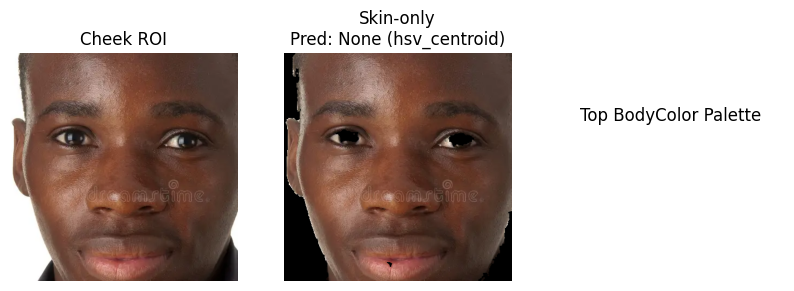

In [29]:
print("\n=== RUNNING INFERENCE ON UPLOADED IMAGES ===")
results = []
# helper: convert color name to RGB approximate (a small dict you can extend)
NAMED_COLOR_MAP = {
    "peach": (255,218,185), "light pink": (255,182,193), "sky blue": (135,206,235),
    "mint green": (152,255,152), "lavender": (230,230,250), "cream": (255,253,208),
    "maroon": (128,0,0), "mustard": (255,219,88), "teal": (0,128,128),
    "olive green": (128,128,0), "coral": (255,127,80), "rust": (183,65,14),
    "royal blue": (65,105,225), "emerald green": (80,200,120), "wine": (114,47,55),
    "gold": (212,175,55), "deep purple": (102,0,153), "deep red": (153,0,0), "navy": (0,0,128)
}

uploaded_image_files = list(uploaded_imgs.keys())
for img_name in uploaded_image_files:
    img_path = os.path.join(IMAGES_DIR, img_name)
    face_crop, skin_only, mask = extract_cheek_and_skin_mask(img_path)
    if face_crop is None:
        print("No face detected for", img_name); continue
    # visualize later; compute mean HSV
    if skin_only is not None and np.any(skin_only != [0,0,0]):
        hsv_img = cv2.cvtColor(skin_only, cv2.COLOR_RGB2HSV)
        mask_bool = np.any(skin_only != [0,0,0], axis=2)
        mean_h = float(hsv_img[:,:,0][mask_bool].mean())
        mean_s = float(hsv_img[:,:,1][mask_bool].mean())
        mean_v = float(hsv_img[:,:,2][mask_bool].mean())
    else:
        hsv_img = cv2.cvtColor(face_crop, cv2.COLOR_RGB2HSV)
        mean_h = float(hsv_img[:,:,0].mean()); mean_s = float(hsv_img[:,:,1].mean()); mean_v = float(hsv_img[:,:,2].mean())
    # predict label: prefer CNN if available otherwise HSV centroid
    if trained_model is not None:
        try:
            roi_resized = cv2.resize(face_crop, IMG_SIZE)
            arr = roi_resized.astype(np.float32)/255.0
            probs = trained_model.predict(np.expand_dims(arr, axis=0))[0]
            best_idx = int(np.argmax(probs)); pred_label = le.inverse_transform([best_idx])[0]
            model_used = "deep_cnn"
        except Exception:
            pred_label = classify_hsv_nearest([mean_h, mean_s, mean_v])
            model_used = "hsv_centroid"
    else:
        pred_label = classify_hsv_nearest([mean_h, mean_s, mean_v])
        model_used = "hsv_centroid"
    # Rule-based filter: allowed body colors for this predicted tone
    allowed = rules_map.get(pred_label, None)
    if allowed is None or len(allowed)==0:
        # fallback: allow all
        candidate_df = train_df.copy()
    else:
        # filter dataset rows that have BodyColor in allowed list and same skin tone label if you want
        candidate_df = train_df[train_df["BodyColor"].str.lower().isin([c.lower() for c in allowed])].copy()
        # if no rows remain, fallback to all
        if candidate_df.shape[0]==0:
            candidate_df = train_df.copy()
    # Prepare features for ranking
    X_cand = candidate_df[X_cols].values
    # Predict score using XGBoost
    candidate_df["pred_score"] = xgb_model.predict(X_cand)
    candidate_df = candidate_df.sort_values("pred_score", ascending=False)
    top = candidate_df.head(TOP_K)
    # Prepare recommended color list: BodyColor + BorderColor + FabricType (first TOP_K rows)
    recs = []
    for _, r in top.iterrows():
        recs.append({
            "BodyColor": r["BodyColor"],
            "BorderColor": r["BorderColor"],
            "FabricType": r["FabricType"],
            "Occasion": r["Occasion"]
        })
    # Visualize original, skin-only, and palette
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.imshow(face_crop); plt.title("Cheek ROI"); plt.axis('off')
    if skin_only is not None:
        plt.subplot(1,3,2); plt.imshow(skin_only); plt.title(f"Skin-only\nPred: {pred_label} ({model_used})"); plt.axis('off')
    else:
        plt.subplot(1,3,2); plt.imshow(face_crop); plt.title(f"No skin-mask\nPred: {pred_label}"); plt.axis('off')
    # palette – show top 5 BodyColor boxes (use named map or random color)
    plt.subplot(1,3,3)
    palette = np.ones((100, 300, 3), dtype=np.uint8)*255
    n = min(5, len(top))
    for i in range(n):
        colname = str(top.iloc[i]["BodyColor"]).strip().lower()
        rgb = NAMED_COLOR_MAP.get(colname, (int(np.random.randint(50,230)), int(np.random.randint(50,230)), int(np.random.randint(50,230))))
        palette[:, i*(300//n):(i+1)*(300//n), :] = rgb[::-1]  # convert to BGR display reversed if needed
    plt.imshow(cv2.cvtColor(palette, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title("Top BodyColor Palette")
    plt.show()
    # Save result row
    result_row = {
        "Image": img_name,
        "PredictedTone": pred_label,
        "ModelUsed": model_used,
        "MeanH": mean_h, "MeanS": mean_s, "MeanV": mean_v,
        "Recommendations": recs
    }
    results.append(result_row)


In [30]:
# 12) Display recommendations directly to the console

print("\n\n=== FINAL RECOMMENDATIONS ===")
for r in results:
    print(f"\nImage: {r['Image']}")
    print(f"Predicted Skin Tone: {r['PredictedTone']}")
    print(f"Model Used: {r['ModelUsed']}")
    print("--- Top Recommendations ---")

    # Check if there are any recommendations
    if r['Recommendations']:
        for i, rec in enumerate(r['Recommendations']):
            print(f"  {i+1}. Body Color: {rec['BodyColor']}, Border Color: {rec['BorderColor']}, Fabric: {rec['FabricType']}, Occasion: {rec['Occasion']}")
    else:
        print("  No recommendations found.")

print("\nDONE. If you want improvements: (A) Increase IMG_SIZE to 224 for better CNN accuracy, (B) unfreeze EfficientNet and fine-tune with low lr, (C) add >200 labelled images per skin class, (D) add exact RGB values for BodyColor in dataset to render precise palettes.")



=== FINAL RECOMMENDATIONS ===

Image: portrait-young-black-man-7542628 (2).webp
Predicted Skin Tone: None
Model Used: hsv_centroid
--- Top Recommendations ---
  No recommendations found.

DONE. If you want improvements: (A) Increase IMG_SIZE to 224 for better CNN accuracy, (B) unfreeze EfficientNet and fine-tune with low lr, (C) add >200 labelled images per skin class, (D) add exact RGB values for BodyColor in dataset to render precise palettes.
